In [1]:
import numpy as np
import tensorflow as tf
import sys
import string
import json

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


## Prepare data

In [2]:
def load_data(data_file=None):
    if data_file == None:
        return
    with open(data_file) as f:
        data = json.load(f)
    return data

In [3]:
folder = './data/large_files/stanford_sentiment/parsed_data/'
word2idx = load_data(folder + "sentiment_word2idx.json")
sentiment_binary_train = load_data(folder + "sentiment_binary_train.json")
sentiment_train = load_data(folder + "sentiment_train.json")
sentiment_binary_test = load_data(folder + "sentiment_binary_test.json")
sentiment_test = load_data(folder + "sentiment_test.json")

In [4]:
# the loaded samples has three type of labels -1,0,1, in which -1 indicates neutral sentiment.
# We exclude samples with neutral sentiment.
def exclude_neutral_sample(samples:dict):
    ssamples = {}
    for k, v in samples.items():
        if v[3][-1] != -1:
            ssamples[k] = v
    return ssamples
        
train_b = exclude_neutral_sample(sentiment_binary_train)
test_b = exclude_neutral_sample(sentiment_binary_test)

print("After filtering: # of training samples and # of test samples")
print("# of traing samples: ", len(train_b))
print("# of test samples: ", len(test_b))

After filtering: # of training samples and # of test samples
# of traing samples:  6920
# of test samples:  1821


In [5]:
def get_comment(wordidx, idx2word:dict):
    wordlist = []
    for idx in wordidx:
        if idx != -1:
            token = idx2word[idx]
            if token not in string.punctuation:
                wordlist.append(token)
    return wordlist

In [6]:
def get_comments_samples(samples:dict, idx2word:dict):
    comments = []
    targets = []
    for _, v in samples.items():
        if v[3][-1] != -1:
            comment = " ".join(get_comment(v[0], idx2word))
            label = v[3][-1]
            comments.append(comment)
            targets.append(label) 
    return comments, targets

In [7]:
idx2word = {v:k for k, v in word2idx.items()}
train_comments_o, train_targets = get_comments_samples(train_b, idx2word)
test_comments_o, test_targets = get_comments_samples(test_b, idx2word)

vocabulary_size = len(idx2word)
print('vocabulary_size' , vocabulary_size)

vocabulary_size 18647


In [9]:
# print(type(train_comments_o))
# print(len(train_comments_o))
# print(len(train_targets))
# print(len(test_comments_o))
# print(len(test_targets))
# print(train_comments_o[1])
# print(train_targets[1])

## Preprocessing and analyzing data

### Define functions

In [10]:
def remove_punctuation(samples):
    filtered_samples = []
    for i in samples:
        filtered_samples.append(i.translate(str.maketrans('', '', string.punctuation)))
    return filtered_samples

In [11]:
# test
# remove_punctuation(["Today's so beautiful!"])

In [12]:
def tokenize(samples):
    tokenized_samples = []
    for s in samples:
        tokens = word_tokenize(s)
        tokenized_samples.append(tokens)
    return tokenized_samples

In [13]:
# test
# tokenize(['Todays so beautiful'])

In [14]:
stopWords = set(stopwords.words('english'))
print(stopWords)

{'ourselves', 'after', 'few', 'was', 'had', 'off', 'under', "hasn't", 'why', 'mustn', 'before', 'yourself', 'own', 'because', 'now', 'between', 'above', 'hers', "you'd", 'o', 'if', "won't", 'they', 'y', 'over', 'his', 'when', 'her', 'once', 'while', 'them', 'itself', 'down', 'mightn', "that'll", 'hasn', 'me', 'did', 'both', 'have', "haven't", "needn't", 'same', 'then', 'we', 'into', 'which', 'no', 'he', 'who', "couldn't", 'shan', 'weren', 'ma', 're', "wasn't", 'of', 'there', 'an', "you've", 'should', "weren't", 'this', 'the', 'through', "don't", 'for', 'our', 'herself', 'on', 'can', 'doesn', 'hadn', "hadn't", 'is', 'or', 'with', 'all', 'more', 'needn', 'whom', 'and', 'yours', 'most', 'isn', 'you', 'been', 'myself', 'a', "shouldn't", 'their', 'don', "aren't", 'it', 'be', 'other', 'from', 'not', 'do', 'him', "you'll", 'where', 'those', 'ain', "didn't", 'about', 'how', 's', 'here', 'my', 'yourselves', 'its', 'does', 'than', 'haven', 'couldn', 'will', 'each', 'until', 'too', "you're", 'but

In [15]:
stopWords_revised = set(('at', 'how', 'each', 's', 'those', 'from','whom', 'if', 're', 'we', 'by','into', 'it', 'ma', 'than', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
             'which', 'now', 'ours', 'in', "you've", 'before', 'further', 'below', 'did',  'who', 'once', 'some', 'being', 
             'does', 'too', 'herself', 'about', 'my', 'are', 'during', 'few', 'an', 'do', 'over',  'themselves', 'the', 'why', 'a', 'same', 'all', 
             'own', 'with', 'under', 'myself', 'he', 'because', 'again', 'himself', 'these', 'that', 'am', 'through', 'll', 'so', 've', "you're", 'doing', 'between', 
             'when', 'ourselves', 'been', 'of', 'our', 'them', 'their', 'while', 'as', 'can', 'where', 'such', 'yourself', 'haven', 'they', 'theirs', 'm', 'both', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 'more', 
                'd', 'o', 'what', 'having', 't', 'this', 'after', 'no', 'then', 'above', 'out', 'nor', "should've", 'his', 
               "you'd", "she's", 'and', 'shan', 'until', 'here', 'for', 'just', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [16]:
stopWords_revised_2 = set(('at', 'each', 's', 'those', 'from', 'if', 're', 'we', 'by','into', 'it', 'ma', "you'll", 
             'very', 'was', 'is', 'be', 'had', 'you', 'hers', 'off', 'her', 'your', 'other', 'on', 'down', 'its', 'should', 
              'now', 'ours', 'in', "you've", 'below', 'did', 'being', 
             'does', 'herself', 'about', 'my', 'are', 'an', 'do', 'themselves', 'the',  'a',  
             'own', 'myself', 'he',  'himself', 'these', 'that', 'am', 'll', 'so', 've', "you're", 'doing', 
            'ourselves', 'been', 'of', 'our', 'them', 'their', 'can', 'yourself', 'they', 'theirs', 'm', 
                     "that'll", 'or', 'were', 'up', 'will', 'me', 'yours', 'itself', 'has', 
                'd', 'o', 'having', 't', 'this', 'after', 'then', 'out', "should've", 'his', 
               "you'd", "she's", 'shan',  'here', 'for', 'him', 'to', 'have', 'she', 'yourselves', "it's", 'y', 'i', 'there'))


In [17]:
def remove_stopwords(samples):
    filtered_samples = []
    for s in samples:
        filstered_tokens = []
        for w in s:
            if w not in stopWords_revised_2:
                filstered_tokens.append(w)
        filtered_samples.append(filstered_tokens)
    return filtered_samples    

In [18]:
# test
# remove_stopwords([['Todays', 'so', 'not', 'beautiful']])

### Start preprocessing data
* Remove stopwords
* Remove punctuation
* Tokenization
* Change the representation of training/test data to integer

**Orginal Data**

In [19]:
# Test

# for i in range(100):
#     print(i, ": ", train_comments_o[i])

**Perserve n't**

In [20]:
train_comments_1 = []
for comment in train_comments_o:
    new_str = comment.replace("n't", 'not')
    train_comments_1.append(new_str)
    
test_comments_1 = []
for comment in test_comments_o:
    new_str = comment.replace("n't", 'not')
    test_comments_1.append(new_str)

In [21]:
# Test

# for i in range(100):
#     print(i, ": ", train_comments_1[i])

**Remove punctuation**

In [22]:
train_comments_punc = remove_punctuation(train_comments_1)
test_comments_punc = remove_punctuation(test_comments_1)
print("punctuation removed")

punctuation removed


In [23]:
# Test

# for i in range(100):
#     print(i, ": ", train_comments_punc[i])

**Tokenize**

In [24]:
train_comments_tokenized = tokenize(train_comments_punc)
test_comments_tokenized = tokenize(test_comments_punc)
print("tokenized")

tokenized


In [25]:
# Test

# for i in range(100):
#     print(i, ": ", train_comments_tokenized[i])

**Remove stopwords**

In [26]:
train_comments_stopwords = remove_stopwords(train_comments_tokenized)
test_comments_stopwords = remove_stopwords(test_comments_tokenized)
print("stopwords removed")

stopwords removed


In [27]:
# Test

# for i in range(100):
#     print(i, ": ", train_comments_stopwords[i])

In [28]:
def combine(tokenized_comments):
    text = []
    for comment in tokenized_comments:
        text += comment
    return text

all_words = combine(train_comments_stopwords) + combine(test_comments_stopwords)
# print(all_words)
# all_text1 = ' '.join(train_comments_stopwords)
# all_text2 = ' '.join(test_comments_stopwords)
# words1 = all_text1.split()
# words2 = all_text2.split()
# all_words = words1 + words2

In [29]:
# Create your dictionary that maps vocab words to integers here
from collections import Counter
counts = Counter(all_words)
print(type(counts))

vocab = sorted(counts, key=counts.get, reverse=True)

# Create words-to-index map. 
# Note that index start from 1
vocab_to_int = {word:i for i, word in enumerate(vocab, 1)}

<class 'collections.Counter'>


In [30]:
print("type of vocab", type(vocab))
print('total # of words: ', len(vocab_to_int))
print("first word:", vocab[0])
print("last word:", vocab[-1])
print("first word index:", vocab_to_int[vocab[0]])
print("last word index", vocab_to_int[vocab[-1]])

type of vocab <class 'list'>
total # of words:  16547
first word: and
last word: fizzles
first word index: 1
last word index 16547


In [31]:
# Create index-to-words map.
index2word = {idx:word for word, idx in vocab_to_int.items()}

In [32]:
def convert_to_int(reviews, vocab_to_int):
    # Convert the reviews to integers, same shape as reviews list, but with integers
    print('# of reviews before index: ', len(reviews))
    reviews_ints = []
    for review in reviews:
        reviews_ints.append([vocab_to_int[word] for word in review])

    print('# of reviews after index: ', len(reviews_ints))
    return reviews_ints

In [33]:
# convert the representation of training examples from text to integer
x_train = convert_to_int(train_comments_stopwords, vocab_to_int)

# of reviews before index:  6920
# of reviews after index:  6920


In [34]:
# Test

print(x_train[7])
print(train_comments_o[7])
text = [index2word[idx] for idx in x_train[7]]
print(text)

[1119, 305, 5, 10031, 447, 4621, 15249, 13620, 5536, 90, 900, 2187, 10677, 5, 154, 3015, 6135, 305, 238, 397, 74, 692]
aside from the fact that the film idiotically uses the website feardotcom.com or the improperly hammy performance from poor stephen rea the film gets added disdain for the fact that it is nearly impossible to look at or understand
['aside', 'fact', 'film', 'idiotically', 'uses', 'website', 'feardotcomcom', 'improperly', 'hammy', 'performance', 'poor', 'stephen', 'rea', 'film', 'gets', 'added', 'disdain', 'fact', 'nearly', 'impossible', 'look', 'understand']


In [35]:
# convert the representation of test examples from text to integer
x_test = convert_to_int(test_comments_stopwords, vocab_to_int)

# of reviews before index:  1821
# of reviews after index:  1821


### Calculate distribution over training/test example length

In [36]:
from collections import Counter

# Create length to frequency map
x_train_lens_map = Counter([len(x) for x in x_train])
x_train_lens = [len(x) for x in x_train]
print("Zero-length reviews: {}".format(x_train_lens_map[0]))
print("Maximum train example length: {}".format(max(x_train_lens_map)))

Zero-length reviews: 2
Maximum train example length: 36


In [37]:
# Create length to frequency map
x_test_lens_map = Counter([len(x) for x in x_test])
x_test_lens = [len(x) for x in x_test]
print("Zero-length reviews: {}".format(x_test_lens_map[0]))
print("Maximum test example length: {}".format(max(x_test_lens_map)))


ave_len = 0
for i in x_train:
    ave_len += len(i) 
ave_len = ave_len / len(x_train)
print(ave_len)

ave_len = 0
for i in x_test:
#     print(i)
    ave_len += len(i)  
ave_len = ave_len / len(x_test)
print(ave_len)


Zero-length reviews: 0
Maximum test example length: 31
11.324566473988439
11.314662273476111


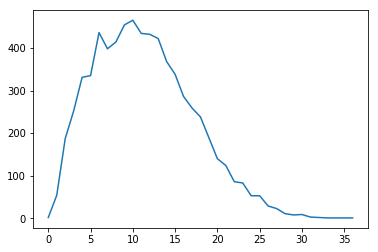

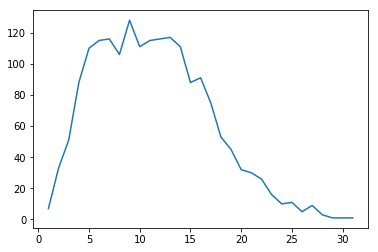

In [38]:
import matplotlib.pyplot as plt
plt.plot(list(x_train_lens_map.keys()), list(x_train_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

plt.plot(list(x_test_lens_map.keys()), list(x_test_lens_map.values()))
# plt.axis([1000, 1500, 0, 55])
plt.show()

In [39]:
def left_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    print(features.shape)
    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # left padding
        features[i, -len(row):] = np.array(row)[:seq_len]
        
        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths


In [40]:
def right_padding(reviews_ints, seq_len):
    
    # The features created here are the data that we are going to train and test the network

    # Create features with shape (len(reviews_ints), seq_len) and initialized with zeros
    features = np.zeros((len(reviews_ints), seq_len), dtype=int)

    print(features.shape)
    # Create list holding the length for each review
    lengths = []

    # row is the review in forms of a list of integers
    for i, row in enumerate(reviews_ints):

        # right padding
        features[i, :len(row)] = np.array(row)[:seq_len]

        # record the length of each review. This might be useful when we want to use sequence_length argument
        # of tf.nn.dynamic_rnn(...)
        lengths.append(len(row) if len(row) < seq_len else seq_len)
        
    return features, lengths

In [41]:
## Test

# sample1 = [4,6,7,2,3,5,7,8,1]
# sample2 = [1,2,3,4,6,7,2,3,5,7]
# sample3 = [1,2,3,4,6,7,2,3,26,1, 11, 12]
# sample4 = [8,7,3]
# samples = []
# samples.append(sample1)
# samples.append(sample2)
# samples.append(sample3)
# samples.append(sample4)
# features_, lengths_ = left_padding(samples, 10)

# print(features_)
# print(lengths_)

In [42]:
# Exclude training/test examples with 0 length. It is possible that some examples may have 0 length since we did 
# punctuation and stopword removing. 

x_train_f = []
y_train_f = []
for idx in range(len(x_train)):
    if len(x_train[idx]) != 0:
        x_train_f.append(x_train[idx])
        y_train_f.append(train_targets[idx])

x_test_f = []
y_test_f = []
for idx in range(len(x_test)):
    if len(x_test[idx]) != 0:
        x_test_f.append(x_test[idx])
        y_test_f.append(test_targets[idx])

In [43]:
# perform padding
seq_len = 36
x_train_p, x_train_len = left_padding(x_train_f, seq_len)
x_test_p, x_test_len = left_padding(x_test_f, seq_len)

(6918, 36)
(1821, 36)


In [44]:
# Test

# print(x_train_p[:5,:seq_len])
# print(x_train_len[:5])

** Resplit training data **

In [45]:
# Add more data for training, since RNN consumes lots of data

x_train_ = np.append(x_train_p, x_test_p[:1086], axis=0)
x_test_ = x_test_p[1086:]

y_train_ = np.array(np.append(y_train_f, y_test_f[:1086], axis=0))
y_test_ = np.array(y_test_f[1086:])

x_train_len_ = np.append(x_train_len, x_test_len[:1086], axis=0)
x_test_len_ = x_test_len[1086:]

print(len(x_train_))
print(len(x_test_))
print(len(y_train_))
print(len(y_test_))
print(len(x_train_len_))
print(len(x_test_len_))

8004
735
8004
735
8004
735


In [46]:
# print(x_train_.shape)
# print(x_test_.shape)
# print(y_train_.shape)
# print(y_test_.shape)

## Model

In [47]:
def get_batches(x, y, lengths, batch_size):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(x) == len(y)
    n_batches = len(x)//batch_size

    # Only get full batches
    features, labels = x[:n_batches*batch_size], y[:n_batches*batch_size]
    
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
#         print("start_i", start_i)
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i], lengths[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches

In [49]:
tf.reset_default_graph()

### Run Bidirectional LSTM Model

In [808]:
def BiLSTM_RNN_Model(vocab_size, learning_rate = 0.001, embedding_dim = 300, 
                   lstm_size = 256, num_lstm_layer = 1, batch_size = 200, keep_probability=0.8, epochs=400):
    
    graph = tf.Graph()
    with graph.as_default():

        # input placeholders
        inputs = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
        labels = tf.placeholder(tf.float32, shape=[None, None], name='labels')
    #     seq_len = tf.placeholder(tf.int32, shape=[None], name='seq_len')
        keep_prob = tf.placeholder(tf.float32, name = "keep_prob")

        # embedding layer
        embedding = tf.Variable(tf.random_uniform((vocab_size, embedding_dim), -1, 1), name = 'embedding')
        embed = tf.nn.embedding_lookup(embedding, inputs)


        # LSTM layer
        with tf.name_scope("biLSTM"):
            with tf.variable_scope("forward"):
                fw_cell = tf.nn.rnn_cell.LSTMCell(num_units=lstm_size)
#                 fw_cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
                fw_cell = tf.contrib.rnn.DropoutWrapper(fw_cell, output_keep_prob = keep_prob)
            with tf.variable_scope("backward"):
                bw_cell = tf.nn.rnn_cell.LSTMCell(num_units=lstm_size)
#                 bw_cell = tf.contrib.rnn.BasicLSTMCell(lstm_size)
                bw_cell = tf.contrib.rnn.DropoutWrapper(bw_cell, output_keep_prob = keep_prob)

        initial_state_fw = fw_cell.zero_state(batch_size, tf.float32)
        initial_state_bw = bw_cell.zero_state(batch_size, tf.float32)

        outputs, final_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=fw_cell, cell_bw=bw_cell,
                                                    inputs=embed,
    #                                                 sequence_length=seq_len,
                                                    initial_state_fw=initial_state_fw,
                                                    initial_state_bw=initial_state_bw,
                                                    scope="biLSTM")


        outputs = tf.concat(axis = 2, values = outputs)

        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.nn.sigmoid)

    #     cost = tf.losses.mean_squared_error(labels, predictions)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=predictions)
        entroy = tf.reduce_mean(cost)
        

#         # Optimizer for training, using gradient clipping to control exploding gradients
#         tvars = tf.trainable_variables()
#         # grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
#         grads = tf.gradients(entroy, tvars)
#         clip_grads, _ = tf.clip_by_global_norm(grads, 5.0)
#         train_op = tf.train.AdamOptimizer(learning_rate)
#         optimizer = train_op.apply_gradients(zip(clip_grads, tvars))
    
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(entroy)

        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), tf.cast(tf.round(labels), tf.int32))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    with graph.as_default():
        saver = tf.train.Saver()
    
    with tf.Session(graph=graph) as sess:
        
        sess.run(tf.global_variables_initializer())
        iteration = 1
        
        for e in range(epochs):

    #         state = sess.run(initial_state)
            state_fw = sess.run(initial_state_fw)
            state_bw = sess.run(initial_state_bw)

            for batch_features, batch_labels, batch_len in get_batches(x_train_, y_train_, x_train_len_, batch_size):
    #             batch_len = np.array(batch_len)

                feed = {inputs: batch_features,
                        labels: batch_labels[:, None],   # change ths shape of y to [batch_size, 1]
    #                     seq_len: batch_len,
                        keep_prob: keep_probability,
                        initial_state_fw: state_fw,
                        initial_state_bw: state_bw}
                loss, state, _ = sess.run([entroy, final_state, optimizer], feed_dict=feed)
                state_fw, state_bw = state

                if iteration%5==0:
    #                   print(loss)
                        print("Epoch: {}/{}".format(e, epochs),
                              "Iteration: {}".format(iteration),
                              "Train loss: {:.3f}".format(loss))

                if iteration%25==0:
                    val_acc = []
                    val_state_fw = sess.run(fw_cell.zero_state(batch_size, tf.float32))
                    val_state_bw = sess.run(bw_cell.zero_state(batch_size, tf.float32))

                    for x, y, batch_len in get_batches(x_test_, y_test_, x_test_len_, batch_size):
                        feed = {inputs: x,
                                labels: y[:, None],
    #                             seq_len: batch_len,
                                keep_prob: 1,  # note the keep probablity is 1 here
                                initial_state_fw: val_state_fw,
                                initial_state_fw: val_state_bw}
                        batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                        val_acc.append(batch_acc)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1

        saver.save(sess, "checkpoints/sentiment.ckpt")

In [809]:
vocab_size = len(vocab_to_int) + 1
num_lstm_layer = 1

epochs = 40

batch_sizes = [400]

embedding_dims = [256]
lstm_sizes = [128, 256]
learning_rates = [0.001, 0.005]
keep_probabilities = [0.7, 0.8]

# embedding_dims = [200, 300, 400]
# lstm_sizes = [128, 256]
# learning_rates = [0.001, 0.0005, 0.0001]
# keep_probabilities = [0.6, 0.8, 1.0]

# Grid Search
for batch_size in batch_sizes:
    for embedding_dim in embedding_dims:
        for lstm_size in lstm_sizes:
            for learning_rate in learning_rates:
                for keep_probability in keep_probabilities:
                    print("---------------------------------------------")
                    print("Start with new set of hyperparameters:")
                    print("batch_size", batch_size)
                    print("embedding_dim", embedding_dim)
                    print("lstm_size", lstm_size)
                    print("learning_rate", learning_rate)
                    print("keep_probability", keep_probability)
                    BiLSTM_RNN_Model(vocab_size, learning_rate, embedding_dim, lstm_size, num_lstm_layer, 
                       batch_size, keep_probability, epochs)

---------------------------------------------
Start with new set of hyperparameters:
batch_size 400
embedding_dim 256
lstm_size 128
learning_rate 0.001
keep_probability 0.7
Epoch: 0/40 Iteration: 5 Train loss: 0.694
Epoch: 0/40 Iteration: 10 Train loss: 0.694
Epoch: 0/40 Iteration: 15 Train loss: 0.692
Epoch: 0/40 Iteration: 20 Train loss: 0.685
Epoch: 1/40 Iteration: 25 Train loss: 0.676
Val acc: 0.642
Epoch: 1/40 Iteration: 30 Train loss: 0.691
Epoch: 1/40 Iteration: 35 Train loss: 0.677
Epoch: 1/40 Iteration: 40 Train loss: 0.655
Epoch: 2/40 Iteration: 45 Train loss: 0.638
Epoch: 2/40 Iteration: 50 Train loss: 0.654
Val acc: 0.707
Epoch: 2/40 Iteration: 55 Train loss: 0.638
Epoch: 2/40 Iteration: 60 Train loss: 0.615
Epoch: 3/40 Iteration: 65 Train loss: 0.603
Epoch: 3/40 Iteration: 70 Train loss: 0.611
Epoch: 3/40 Iteration: 75 Train loss: 0.603
Val acc: 0.738
Epoch: 3/40 Iteration: 80 Train loss: 0.574
Epoch: 4/40 Iteration: 85 Train loss: 0.575
Epoch: 4/40 Iteration: 90 Train los

Epoch: 0/40 Iteration: 15 Train loss: 0.691
Epoch: 0/40 Iteration: 20 Train loss: 0.685
Epoch: 1/40 Iteration: 25 Train loss: 0.671
Val acc: 0.630
Epoch: 1/40 Iteration: 30 Train loss: 0.693
Epoch: 1/40 Iteration: 35 Train loss: 0.671
Epoch: 1/40 Iteration: 40 Train loss: 0.661
Epoch: 2/40 Iteration: 45 Train loss: 0.632
Epoch: 2/40 Iteration: 50 Train loss: 0.645
Val acc: 0.695
Epoch: 2/40 Iteration: 55 Train loss: 0.632
Epoch: 2/40 Iteration: 60 Train loss: 0.619
Epoch: 3/40 Iteration: 65 Train loss: 0.589
Epoch: 3/40 Iteration: 70 Train loss: 0.606
Epoch: 3/40 Iteration: 75 Train loss: 0.591
Val acc: 0.733
Epoch: 3/40 Iteration: 80 Train loss: 0.578
Epoch: 4/40 Iteration: 85 Train loss: 0.556
Epoch: 4/40 Iteration: 90 Train loss: 0.579
Epoch: 4/40 Iteration: 95 Train loss: 0.570
Epoch: 4/40 Iteration: 100 Train loss: 0.556
Val acc: 0.757
Epoch: 5/40 Iteration: 105 Train loss: 0.534
Epoch: 5/40 Iteration: 110 Train loss: 0.562
Epoch: 5/40 Iteration: 115 Train loss: 0.564
Epoch: 5/40 

Epoch: 2/40 Iteration: 45 Train loss: 0.557
Epoch: 2/40 Iteration: 50 Train loss: 0.557
Val acc: 0.733
Epoch: 2/40 Iteration: 55 Train loss: 0.543
Epoch: 2/40 Iteration: 60 Train loss: 0.542
Epoch: 3/40 Iteration: 65 Train loss: 0.528
Epoch: 3/40 Iteration: 70 Train loss: 0.534
Epoch: 3/40 Iteration: 75 Train loss: 0.532
Val acc: 0.738
Epoch: 3/40 Iteration: 80 Train loss: 0.527
Epoch: 4/40 Iteration: 85 Train loss: 0.516
Epoch: 4/40 Iteration: 90 Train loss: 0.526
Epoch: 4/40 Iteration: 95 Train loss: 0.526
Epoch: 4/40 Iteration: 100 Train loss: 0.530
Val acc: 0.740
Epoch: 5/40 Iteration: 105 Train loss: 0.510
Epoch: 5/40 Iteration: 110 Train loss: 0.519
Epoch: 5/40 Iteration: 115 Train loss: 0.525
Epoch: 5/40 Iteration: 120 Train loss: 0.515
Epoch: 6/40 Iteration: 125 Train loss: 0.506
Val acc: 0.765
Epoch: 6/40 Iteration: 130 Train loss: 0.518
Epoch: 6/40 Iteration: 135 Train loss: 0.522
Epoch: 6/40 Iteration: 140 Train loss: 0.512
Epoch: 7/40 Iteration: 145 Train loss: 0.505
Epoch:

Epoch: 3/40 Iteration: 75 Train loss: 0.532
Val acc: 0.798
Epoch: 3/40 Iteration: 80 Train loss: 0.524
Epoch: 4/40 Iteration: 85 Train loss: 0.516
Epoch: 4/40 Iteration: 90 Train loss: 0.521
Epoch: 4/40 Iteration: 95 Train loss: 0.533
Epoch: 4/40 Iteration: 100 Train loss: 0.519
Val acc: 0.808
Epoch: 5/40 Iteration: 105 Train loss: 0.508
Epoch: 5/40 Iteration: 110 Train loss: 0.518
Epoch: 5/40 Iteration: 115 Train loss: 0.522
Epoch: 5/40 Iteration: 120 Train loss: 0.517
Epoch: 6/40 Iteration: 125 Train loss: 0.510
Val acc: 0.777
Epoch: 6/40 Iteration: 130 Train loss: 0.515
Epoch: 6/40 Iteration: 135 Train loss: 0.522
Epoch: 6/40 Iteration: 140 Train loss: 0.516
Epoch: 7/40 Iteration: 145 Train loss: 0.509
Epoch: 7/40 Iteration: 150 Train loss: 0.520
Val acc: 0.793
Epoch: 7/40 Iteration: 155 Train loss: 0.519
Epoch: 7/40 Iteration: 160 Train loss: 0.519
Epoch: 8/40 Iteration: 165 Train loss: 0.509
Epoch: 8/40 Iteration: 170 Train loss: 0.519
Epoch: 8/40 Iteration: 175 Train loss: 0.522


Val acc: 0.728
Epoch: 5/40 Iteration: 105 Train loss: 0.555
Epoch: 5/40 Iteration: 110 Train loss: 0.590
Epoch: 5/40 Iteration: 115 Train loss: 0.567
Epoch: 5/40 Iteration: 120 Train loss: 0.554
Epoch: 6/40 Iteration: 125 Train loss: 0.537
Val acc: 0.735
Epoch: 6/40 Iteration: 130 Train loss: 0.553
Epoch: 6/40 Iteration: 135 Train loss: 0.547
Epoch: 6/40 Iteration: 140 Train loss: 0.548
Epoch: 7/40 Iteration: 145 Train loss: 0.535
Epoch: 7/40 Iteration: 150 Train loss: 0.545
Val acc: 0.733
Epoch: 7/40 Iteration: 155 Train loss: 0.547
Epoch: 7/40 Iteration: 160 Train loss: 0.539
Epoch: 8/40 Iteration: 165 Train loss: 0.535
Epoch: 8/40 Iteration: 170 Train loss: 0.536
Epoch: 8/40 Iteration: 175 Train loss: 0.542
Val acc: 0.738
Epoch: 8/40 Iteration: 180 Train loss: 0.540
Epoch: 9/40 Iteration: 185 Train loss: 0.524
Epoch: 9/40 Iteration: 190 Train loss: 0.531
Epoch: 9/40 Iteration: 195 Train loss: 0.533
Epoch: 9/40 Iteration: 200 Train loss: 0.536
Val acc: 0.757
Epoch: 10/40 Iteration: 2

Val acc: 0.755
Epoch: 6/40 Iteration: 130 Train loss: 0.551
Epoch: 6/40 Iteration: 135 Train loss: 0.558
Epoch: 6/40 Iteration: 140 Train loss: 0.540
Epoch: 7/40 Iteration: 145 Train loss: 0.532
Epoch: 7/40 Iteration: 150 Train loss: 0.545
Val acc: 0.745
Epoch: 7/40 Iteration: 155 Train loss: 0.552
Epoch: 7/40 Iteration: 160 Train loss: 0.539
Epoch: 8/40 Iteration: 165 Train loss: 0.531
Epoch: 8/40 Iteration: 170 Train loss: 0.543
Epoch: 8/40 Iteration: 175 Train loss: 0.543
Val acc: 0.735
Epoch: 8/40 Iteration: 180 Train loss: 0.539
Epoch: 9/40 Iteration: 185 Train loss: 0.518
Epoch: 9/40 Iteration: 190 Train loss: 0.544
Epoch: 9/40 Iteration: 195 Train loss: 0.538
Epoch: 9/40 Iteration: 200 Train loss: 0.522
Val acc: 0.728
Epoch: 10/40 Iteration: 205 Train loss: 0.517
Epoch: 10/40 Iteration: 210 Train loss: 0.531
Epoch: 10/40 Iteration: 215 Train loss: 0.534
Epoch: 10/40 Iteration: 220 Train loss: 0.519
Epoch: 11/40 Iteration: 225 Train loss: 0.512
Val acc: 0.733
Epoch: 11/40 Iterati

Val acc: 0.770
Epoch: 7/40 Iteration: 155 Train loss: 0.523
Epoch: 7/40 Iteration: 160 Train loss: 0.509
Epoch: 8/40 Iteration: 165 Train loss: 0.502
Epoch: 8/40 Iteration: 170 Train loss: 0.522
Epoch: 8/40 Iteration: 175 Train loss: 0.521
Val acc: 0.775
Epoch: 8/40 Iteration: 180 Train loss: 0.507
Epoch: 9/40 Iteration: 185 Train loss: 0.499
Epoch: 9/40 Iteration: 190 Train loss: 0.519
Epoch: 9/40 Iteration: 195 Train loss: 0.520
Epoch: 9/40 Iteration: 200 Train loss: 0.506
Val acc: 0.793
Epoch: 10/40 Iteration: 205 Train loss: 0.498
Epoch: 10/40 Iteration: 210 Train loss: 0.519
Epoch: 10/40 Iteration: 215 Train loss: 0.518
Epoch: 10/40 Iteration: 220 Train loss: 0.506
Epoch: 11/40 Iteration: 225 Train loss: 0.499
Val acc: 0.788
Epoch: 11/40 Iteration: 230 Train loss: 0.518
Epoch: 11/40 Iteration: 235 Train loss: 0.516
Epoch: 11/40 Iteration: 240 Train loss: 0.503
Epoch: 12/40 Iteration: 245 Train loss: 0.498
Epoch: 12/40 Iteration: 250 Train loss: 0.518
Val acc: 0.780
Epoch: 12/40 It

Val acc: 0.720
Epoch: 8/40 Iteration: 180 Train loss: 0.568
Epoch: 9/40 Iteration: 185 Train loss: 0.538
Epoch: 9/40 Iteration: 190 Train loss: 0.554
Epoch: 9/40 Iteration: 195 Train loss: 0.547
Epoch: 9/40 Iteration: 200 Train loss: 0.550
Val acc: 0.725
Epoch: 10/40 Iteration: 205 Train loss: 0.534
Epoch: 10/40 Iteration: 210 Train loss: 0.533
Epoch: 10/40 Iteration: 215 Train loss: 0.541
Epoch: 10/40 Iteration: 220 Train loss: 0.532
Epoch: 11/40 Iteration: 225 Train loss: 0.517
Val acc: 0.730
Epoch: 11/40 Iteration: 230 Train loss: 0.529
Epoch: 11/40 Iteration: 235 Train loss: 0.538
Epoch: 11/40 Iteration: 240 Train loss: 0.528
Epoch: 12/40 Iteration: 245 Train loss: 0.508
Epoch: 12/40 Iteration: 250 Train loss: 0.523
Val acc: 0.770
Epoch: 12/40 Iteration: 255 Train loss: 0.529
Epoch: 12/40 Iteration: 260 Train loss: 0.521
Epoch: 13/40 Iteration: 265 Train loss: 0.509
Epoch: 13/40 Iteration: 270 Train loss: 0.523
Epoch: 13/40 Iteration: 275 Train loss: 0.527
Val acc: 0.772
Epoch: 13/

### Run LSTM Model

In [806]:
def LSTM_RNN_Model(vocab_size, learning_rate = 0.001, embedding_dim = 300, 
                   lstm_size = 256, num_lstm_layer = 1, batch_size = 200, keep_probability=0.8, epochs=400):

    graph = tf.Graph()
    with graph.as_default():

        # input placeholders
        inputs = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
        labels = tf.placeholder(tf.float32, shape=[None, None], name='labels')
#         seq_len = tf.placeholder(tf.int32, shape=[None], name='seq_len')
        keep_prob = tf.placeholder(tf.float32, name = "keep_prob")

        # embedding layer
        embedding = tf.Variable(tf.random_uniform((vocab_size, embedding_dim), -1, 1), name = 'embedding')
        embed = tf.nn.embedding_lookup(embedding, inputs)


        # LSTM layer
        def build_cell(lstm_units, keep_prob):
            cell = tf.nn.rnn_cell.LSTMCell(num_units=lstm_units)
#             cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_units, activation=tf.nn.relu)
            drop = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = keep_prob)
            return drop

        cell = tf.contrib.rnn.MultiRNNCell([build_cell(lstm_size, keep_prob) for _ in range(num_lstm_layer)])
        initial_state = cell.zero_state(batch_size, tf.float32)

        outputs, final_state = tf.nn.dynamic_rnn(cell, 
                                                 embed, 
#                                                  sequence_length = seq_len,
                                                 initial_state = initial_state)


        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.nn.sigmoid)

    #     cost = tf.losses.mean_squared_error(labels, predictions)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=predictions)
        entroy = tf.reduce_mean(cost)

        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(entroy)

        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), tf.cast(tf.round(labels), tf.int32))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:

        sess.run(tf.global_variables_initializer())
        iteration = 1

        for e in range(epochs):

            state = sess.run(initial_state)

            for batch_features, batch_labels, batch_len in get_batches(x_train_, y_train_, x_train_len_, batch_size):
                batch_len = np.array(batch_len)

                feed = {inputs: batch_features,
                        labels: batch_labels[:, None],   # change ths shape of y to [batch_size, 1]
#                         seq_len: batch_len,
                        keep_prob: keep_probability,
                        initial_state: state}
                loss, state, _ = sess.run([entroy, final_state, optimizer], feed_dict=feed)
            
                if iteration%25==0:
    #                   print(loss)
                        print("Epoch: {}/{}".format(e, epochs),
                              "Iteration: {}".format(iteration),
                              "Train loss: {:.3f}".format(loss))

                if iteration%25==0:
                    val_acc = []
                    val_state = sess.run(cell.zero_state(batch_size, tf.float32))

                    for x, y, batch_len in get_batches(x_test_, y_test_, x_test_len_, batch_size):
                        feed = {inputs: x,
                                labels: y[:, None],
#                                 seq_len: batch_len,
                                keep_prob: 1,  # note the keep probablity is 1 here
                                initial_state: val_state}
                        batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                        val_acc.append(batch_acc)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1

        saver.save(sess, "checkpoints/sentiment.ckpt")

In [807]:
vocab_size = len(vocab_to_int) + 1
num_lstm_layer = 1

epochs = 30

# batch_size 400
# embedding_dim 300
# lstm_size 128
# learning_rate 0.005
# keep_probability 0.8

batch_sizes = [400]

embedding_dims = [256]
lstm_sizes = [128, 256]
learning_rates = [0.001, 0.005]
keep_probabilities = [0.7, 0.8]

# embedding_dims = [200, 300, 400]
# lstm_sizes = [128, 256]
# learning_rates = [0.001, 0.0005, 0.0001]
# keep_probabilities = [0.6, 0.8, 1.0]

# Grid Search
for batch_size in batch_sizes:
    for embedding_dim in embedding_dims:
        for lstm_size in lstm_sizes:
            for learning_rate in learning_rates:
                for keep_probability in keep_probabilities:
                    print("-------------------------------------------------------------------")
                    print("Start with new set of hyperparameters:")
                    print("batch_size", batch_size)
                    print("embedding_dim", embedding_dim)
                    print("lstm_size", lstm_size)
                    print("learning_rate", learning_rate)
                    print("keep_probability", keep_probability)
                    LSTM_RNN_Model(vocab_size, learning_rate, embedding_dim, lstm_size, num_lstm_layer, 
                       batch_size, keep_probability, epochs)
            

-------------------------------------------------------------------
Start with new set of hyperparameters:
batch_size 400
embedding_dim 256
lstm_size 128
learning_rate 0.001
keep_probability 0.7
Epoch: 1/30 Iteration: 25 Train loss: 0.673
Val acc: 0.630
Epoch: 2/30 Iteration: 50 Train loss: 0.653
Val acc: 0.700
Epoch: 3/30 Iteration: 75 Train loss: 0.610
Val acc: 0.743
Epoch: 4/30 Iteration: 100 Train loss: 0.561
Val acc: 0.772
Epoch: 6/30 Iteration: 125 Train loss: 0.538
Val acc: 0.728
Epoch: 7/30 Iteration: 150 Train loss: 0.558
Val acc: 0.743
Epoch: 8/30 Iteration: 175 Train loss: 0.541
Val acc: 0.752
Epoch: 9/30 Iteration: 200 Train loss: 0.525
Val acc: 0.765
Epoch: 11/30 Iteration: 225 Train loss: 0.523
Val acc: 0.762
Epoch: 12/30 Iteration: 250 Train loss: 0.528
Val acc: 0.780
Epoch: 13/30 Iteration: 275 Train loss: 0.528
Val acc: 0.785
Epoch: 14/30 Iteration: 300 Train loss: 0.510
Val acc: 0.788
Epoch: 16/30 Iteration: 325 Train loss: 0.503
Val acc: 0.790
Epoch: 17/30 Iteration:

Val acc: 0.760
-------------------------------------------------------------------
Start with new set of hyperparameters:
batch_size 400
embedding_dim 256
lstm_size 256
learning_rate 0.001
keep_probability 0.8
Epoch: 1/30 Iteration: 25 Train loss: 0.666
Val acc: 0.665
Epoch: 2/30 Iteration: 50 Train loss: 0.630
Val acc: 0.702
Epoch: 3/30 Iteration: 75 Train loss: 0.588
Val acc: 0.728
Epoch: 4/30 Iteration: 100 Train loss: 0.559
Val acc: 0.745
Epoch: 6/30 Iteration: 125 Train loss: 0.532
Val acc: 0.743
Epoch: 7/30 Iteration: 150 Train loss: 0.534
Val acc: 0.748
Epoch: 8/30 Iteration: 175 Train loss: 0.535
Val acc: 0.762
Epoch: 9/30 Iteration: 200 Train loss: 0.526
Val acc: 0.762
Epoch: 11/30 Iteration: 225 Train loss: 0.529
Val acc: 0.770
Epoch: 12/30 Iteration: 250 Train loss: 0.531
Val acc: 0.762
Epoch: 13/30 Iteration: 275 Train loss: 0.525
Val acc: 0.740
Epoch: 14/30 Iteration: 300 Train loss: 0.510
Val acc: 0.735
Epoch: 16/30 Iteration: 325 Train loss: 0.510
Val acc: 0.723
Epoch: 1